In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r'C:\Users\sisun\VSCode\DeepLearningDevelopment\src\CrimsonDeepLearning\transformers')
from embeddings.MultiPositionalEncoders import MultiArbitraryPositionalEncoder


import torch

In [2]:

max_lengths = [50, 100]
embedding_dims = [16, 32]
encoder = MultiArbitraryPositionalEncoder(max_lengths, embedding_dims)

# Create two batches of positional IDs for testing
positional_ids_1 = torch.randint(0, 50, (3, 10))  # 3 sequences, 10 positions each, up to 50
positional_ids_2 = torch.randint(0, 100, (3, 10)) # 3 sequences, 10 positions each, up to 100

# Apply the encoder
combined_encoding = encoder.forward([positional_ids_1, positional_ids_2])

# Check the shape of the combined encoding
print(f"Shape of combined encoding: {combined_encoding.shape}")

Shape of combined encoding: torch.Size([3, 10, 48])


## Bi-Directional Positional Encoding Analysis

- The encoding `[:256]` corresponds to the **front positional IDs**.
- The encoding `[256:]` corresponds to the **back positional IDs**.
- The patterns in the embeddings are **anti-symmetric** relative to each other.
- Sequences beyond index `128` are **masked**, meaning they should not contribute to the model's learned patterns.

### Visualization

The following heatmaps provide a visual representation of the positional embeddings for the first sequence in a batch. The heatmaps display the encoding patterns up to sequence index `128`, highlighting the effect of the attention mask.


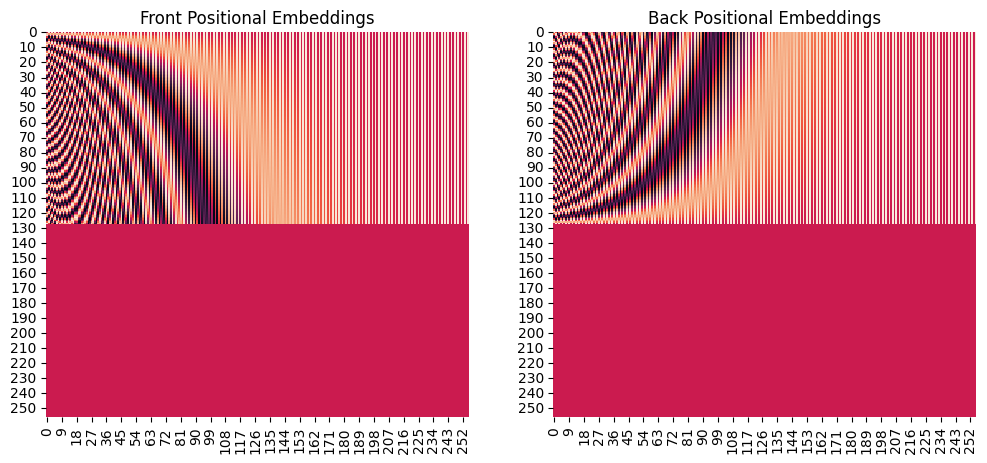

In [3]:

max_len = 256
n_batch, n_seq = 32, 128
d_emb = 512  # Total embedding size for both directions
max_lengths = torch.tensor([max_len, max_len])
embedding_dims = torch.tensor([d_emb//2, d_emb//2])

encoder = MultiArbitraryPositionalEncoder(max_lengths, embedding_dims)

# Initialize tensors with zeros for padding
input_ids = torch.zeros((n_batch, max_len))
front_pos_ids = torch.zeros((n_batch, max_len))
back_pos_ids = torch.zeros((n_batch, max_len))
attention_mask = torch.zeros((n_batch, max_len))

# Random example data and positional IDs
input_ids[:, :n_seq] = torch.randint(0, 10, (n_batch, n_seq))
front_pos_ids[:, :n_seq] = torch.arange(0, n_seq).repeat(n_batch, 1).long()
back_pos_ids[:, :n_seq] = torch.arange(n_seq - 1, -1, -1).repeat(n_batch, 1).long()
attention_mask[:, :n_seq] = 1
attention_mask = attention_mask.long()

output = encoder.forward([front_pos_ids, back_pos_ids], attention_mask=attention_mask)

# Visualization of positional encodings for sequence 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for front positional embeddings
sns.heatmap(output[0, :, :256], ax=axs[0], cbar=False)
axs[0].set_title('Front Positional Embeddings')

# Heatmap for back positional embeddings
sns.heatmap(output[0, :, 256:], ax=axs[1], cbar=False)
axs[1].set_title('Back Positional Embeddings')

plt.show()


## Analysis of Cropped Positional Embeddings

The positional embeddings are cropped to focus on a specific subsequence range (indices 20 to 40). This operation simulates the scenario where only a segment of the input is relevant for the model's task, such as when handling sequences of varying lengths or when focusing on a particular part of the input.

The following visualizations display the positional embeddings for the cropped subsequences:

- **Front Positional Embeddings**: The heatmap shows the pattern for the front positional IDs after cropping, illustrating how the model would interpret the positional information for the selected range.
- **Back Positional Embeddings**: The heatmap for the back positional IDs reveals the anti-symmetric pattern corresponding to the reversed sequence position, again focusing on the cropped range.

This analysis helps in understanding how the model would attend to different positions within a subsequence after applying the attention mask to the cropped inputs.


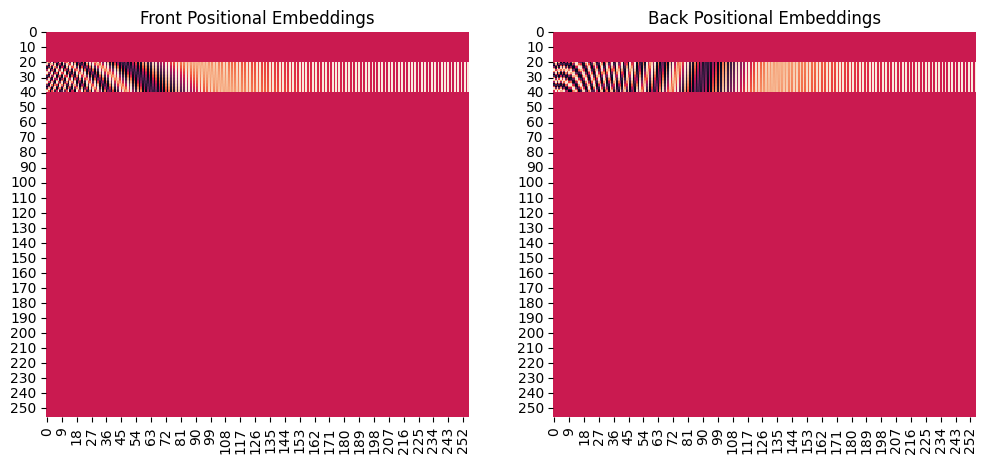

In [4]:
crop_mat = torch.zeros(n_batch, max_len)
crop_mat[:, 20:40] = 1

# Random example data and positional IDs
cropped_input_ids = input_ids * crop_mat
cropped_front_pos_ids = front_pos_ids * crop_mat
cropped_back_pos_ids = back_pos_ids * crop_mat
cropped_attention_mask = attention_mask * crop_mat

output = encoder.forward([cropped_front_pos_ids, cropped_back_pos_ids], attention_mask=cropped_attention_mask)

# Visualization of positional encodings for sequence 0
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for front positional embeddings
sns.heatmap(output[0, :, :256], ax=axs[0], cbar=False)
axs[0].set_title('Front Positional Embeddings')

# Heatmap for back positional embeddings
sns.heatmap(output[0, :, 256:], ax=axs[1], cbar=False)
axs[1].set_title('Back Positional Embeddings')

plt.show()